# Tweets data wrangling
#### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import yaml
import json
import pprint
import tweepy
import time

## Gather
### Twitter Archive

In [2]:
# Create twitter archive DataFrame from the associated csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Tweets image prediction

In [3]:
image_pred_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = image_pred_url.split('/')[-1]

if not os.path.isfile(file_name):
    # Retrieve the file content from the web
    response = requests.get(image_pred_url)
    # And save it in a tsv file
    with open(file_name, mode='wb') as file:
        file.write(response.content)
        
# Create tweet image prediction DataFrame from the downloaded tsv file
df_tweets_img_pred = pd.read_csv(file_name, sep='\t')
df_tweets_img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Tweeter API

In [4]:
# Load the API keys from the yaml file
with open('twitter_api_keys.yaml', mode='r') as file:
    twitter_cred = yaml.load(file, Loader=yaml.FullLoader)
    
consumer_key = twitter_cred['APIKEY']
consumer_secret = twitter_cred['APIKEYSECRET']
access_token = twitter_cred['ACCESSTOKEN']
access_secret = twitter_cred['ACCESSTOKENSECRET']

# Open a tweepy API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

tweet_json_path = 'tweet_json.txt'
overwrite_json_file = False
if overwrite_json_file or not os.path.isfile(tweet_json_path):
    with open(tweet_json_path, 'w') as outfile:
        for idx, tweet_id in df_twitter_archive.tweet_id.iteritems():
            start_time = time.time()
            try:
                tweet_status = api.get_status(tweet_id, tweet_mode='extended')
                if idx > 0:
                    outfile.write("\n")
                json.dump(tweet_status._json, outfile)
                
                print("Tweet {} retrieved from Twitter API in {:.3f} seconds".format(tweet_id, time.time() - start_time))
            except tweepy.TweepError as e:
                print("Tweet {} couldn\'t be retrieved from Twitter API with error: \"{}\"".format(tweet_id, e))               

In [5]:
# Open the json txt file and extract the needed infos from the json data for each tweet saved
if os.path.isfile(tweet_json_path):
    with open(tweet_json_path, 'r') as json_file:
        # Create some columns for the new values retrieved from Twitter API
        df_twitter_archive['retweet_count'] = pd.Series(np.nan, dtype='Int64')
        df_twitter_archive['favorite_count'] = pd.Series(np.nan, dtype='Int64')
        
        # Iterate over each line in the txt file until the end of the file
        json_line = json_file.readline()
        while json_line:
            # Retrieve info from the json data structure
            tweet_json_data = json.loads(json_line)
            tweet_id = tweet_json_data['id']
            retweet_count = tweet_json_data['retweet_count']
            favorite_count = tweet_json_data['favorite_count']
            
            # And copy it in the Twitter archive DataFrame
            df_twitter_archive.loc[df_twitter_archive.tweet_id == tweet_id, 'retweet_count'] = retweet_count
            df_twitter_archive.loc[df_twitter_archive.tweet_id == tweet_id, 'favorite_count'] = favorite_count
            
            json_line = json_file.readline()

In [6]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Assess
### Data Quality
#### df_twitter_archive

- source column should be a human readable category instead of non readable HTML code
- timestamp and retweeted_status_timestamp should be a DateTime instead of a string
- Some rating_numerator and rating_denominator don't follow the Dog Rates convention
- \*_id should be str instead of float
- p1 (dog's breed) string should be formated the same way
- Many dogs have 'a' as name
- Some dogs have multiple dog stage (doggo, pupper or puppo)
- Some tweets have missing retweet_count and favorite_count
- There are less tweets rows in df_tweets_img_pred as in df_twitter_archive

#### df_tweets_img_pred


### Data tidiness

- Retweets shouldn't be part of the dataset
- doggo, pupper and puppo should be one categorical variable
- Dog breed with highest probability and and dog flag variables from df_tweets_img_pred should be part of df_twitter_archive

In [7]:
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
1409,699060279947165696,NaN,NaN,2016-02-15 02:38:53 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Yukon. He pukes rainbows. 12/10 magica...,NaN,NaN,NaN,https://vine.co/v/inlmMHxtqDD,12,10,Yukon,None,None,None,None,1728,3618
1756,678767140346941444,NaN,NaN,2015-12-21 02:41:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mia. She makes awful decisions. 8/10 h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678767140...,8,10,Mia,None,None,None,None,1295,3382
358,830097400375152640,NaN,NaN,2017-02-10 16:53:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Samson. He's absolute fluffy perfection. ...,NaN,NaN,NaN,"https://www.gofundme.com/sick-baby-samson,http...",13,10,Samson,None,None,None,None,2850,9568
837,767754930266464257,NaN,NaN,2016-08-22 16:06:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Philbert. His toilet broke and he does...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/767754930...,11,10,Philbert,None,None,None,None,5257,15685
2172,669327207240699904,NaN,NaN,2015-11-25 01:30:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just got home from college. Dis my dog. She do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669327207...,13,10,None,None,None,None,None,112,535
1711,680497766108381184,NaN,NaN,2015-12-25 21:18:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Percy. He's a Latvian Yuletide Heineken. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680497766...,12,10,Percy,None,None,None,None,1825,4085
1038,744334592493166593,NaN,NaN,2016-06-19 01:02:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Blanket. She has overthrown her human....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744334592...,11,10,Blanket,None,None,None,None,2026,6572
376,828046555563323392,NaN,NaN,2017-02-05 01:04:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sailer. He waits on the roof for his o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/828046555...,13,10,Sailer,None,None,None,None,2798,11509
1556,688828561667567616,NaN,NaN,2016-01-17 21:01:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Brad. His car probably has a spoi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688828561...,9,10,Brad,None,None,None,None,351,1340
958,751456908746354688,NaN,NaN,2016-07-08 16:44:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper that's very hungry but too laz...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751456908...,12,10,None,None,None,pupper,None,977,3136


In [8]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

We can notice that some columns don't have the appropriate type:
- \*_id should be str instead of float or int
- *timestamp should be DateTime instead of str

We can also notice that some tweets have missing retweet_count and favorite_count

In [9]:
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2331.000000,2331.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,2608.168168,7346.697555
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,4412.586286,11409.760061
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,529.000000,1276.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1218.000000,3190.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,3027.500000,8990.500000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,74917.000000,151353.000000


In [10]:
df_twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
           ... 
Roscoe        1
Chevy         1
Winifred      1
Tupawc        1
Rupert        1
Name: name, Length: 957, dtype: int64

We can notice that a lot of dogs are named 'a'

In [11]:
df_twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

We can notice that the source could be simplified to be human readable and changed to a category variable

In [12]:
df_twitter_archive[['doggo', 'pupper', 'puppo']].value_counts()

doggo  pupper  puppo
None   None    None     1985
       pupper  None      245
doggo  None    None       84
None   None    puppo      29
doggo  pupper  None       12
       None    puppo       1
dtype: int64

We can notice that doggo, pupper and puppo should be merged into one variable dog_stage

In [13]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [14]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

We can notice that some rating_numerator and rating_denominator don't follow the Dog Rates convention

In [15]:
df_tweets_img_pred.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
37,666454714377183233,https://pbs.twimg.com/media/CT-5Bs-WUAA2JeC.jpg,1,dalmatian,0.278954,True,Labrador_retriever,0.237612,True,Great_Pyrenees,0.171106,True
662,682638830361513985,https://pbs.twimg.com/media/CXk4W0qWYAMEMEs.jpg,1,English_springer,0.440781,True,Cardigan,0.411182,True,Border_collie,0.022412,True
472,675145476954566656,https://pbs.twimg.com/media/CV6ZOPqWsAA20Uj.jpg,1,Labrador_retriever,0.458746,True,Great_Dane,0.235504,True,Staffordshire_bullterrier,0.116864,True
1617,802323869084381190,https://pbs.twimg.com/media/CyJtSmDUAAA2F9x.jpg,4,home_theater,0.765069,False,television,0.203578,False,entertainment_center,0.018644,False
1537,790698755171364864,https://pbs.twimg.com/media/CvkgUjbUsAEvo7l.jpg,1,Bernese_mountain_dog,0.996541,True,EntleBucher,0.001057,True,Appenzeller,0.000998,True
1768,827199976799354881,https://pbs.twimg.com/media/C3rN-lcWEAA9CmR.jpg,4,Great_Dane,0.869681,True,American_Staffordshire_terrier,0.026658,True,boxer,0.019866,True
1224,744971049620602880,https://pbs.twimg.com/media/ClarNU8VAAEDrDt.jpg,1,toy_poodle,0.497755,True,golden_retriever,0.282017,True,miniature_poodle,0.090032,True
388,673355879178194945,https://pbs.twimg.com/media/CVg9mTYWIAAu7J6.jpg,1,Rottweiler,0.529248,True,miniature_pinscher,0.168296,True,Appenzeller,0.100452,True
1686,814638523311648768,https://pbs.twimg.com/media/C04taUjWIAA6Mo4.jpg,2,golden_retriever,0.650814,True,kuvasz,0.053281,True,cocker_spaniel,0.035440,True
901,700002074055016451,https://pbs.twimg.com/media/CbboKP4WIAAw8xq.jpg,1,Chihuahua,0.369488,True,schipperke,0.243367,True,pug,0.161614,True


In [16]:
df_tweets_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_tweets_img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


We can notice that there are less tweets rows in df_tweets_img_pred as in df_twitter_archive

In [18]:
df_tweets_img_pred.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
rapeseed                1
microwave               1
bison                   1
school_bus              1
military_uniform        1
Name: p1, Length: 378, dtype: int64

We can notice that p1 (dog's breed) string aren't formated the same way

## Clean
### Save a copy of the original data

In [19]:
# Make a copy of the original DataFrame before cleaning them
df_twitter_archive_clean = df_twitter_archive.copy()
df_tweets_img_pred_clean = df_tweets_img_pred.copy()

In [20]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Retweets shouldn't be part of the dataset
#### Define
The retweets shouldn't be considered because they may skew the analysis.. 
Remove the rows where retweeted_status* is not empty and remove then the retweeted_status* columns
#### Code

In [21]:
# Retrieve the retweet indexes
retweets_idx =df_twitter_archive_clean[~df_twitter_archive_clean.retweeted_status_id.isna() |
                                       ~df_twitter_archive_clean.retweeted_status_user_id.isna() |
                                       ~df_twitter_archive_clean.retweeted_status_timestamp.isna()].index
# And drop them from df_twitter_archive_clean
df_twitter_archive_clean.drop(index=retweets_idx, inplace=True)
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [22]:
# Drop the now unused retweet columns
df_twitter_archive_clean.drop(columns=['retweeted_status_id',
                                       'retweeted_status_user_id',
                                       'retweeted_status_timestamp'],
                             inplace=True)

#### Test

In [23]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
 14  retweet_count          2168 non-null   Int64  
 15  favo

### Dog race with highest probability and and dog flag variables from df_tweets_img_pred should be part of df_twitter_archive
This also solve "There are less tweets rows in df_tweets_img_pred as in df_twitter_archive"
#### Define
Merge p1 and p1_dog df_tweets_img_pred_clean into df_twitter_archive_clean on the tweet_id column and rename the merged colums. Keep only the intersection of rows from df_tweets_img_pred and df_twitter_archive. This way, each tweet will have a dog prediction.
#### Code

In [24]:
# Merge p1 and p1_dog df_tweets_img_pred_clean into df_twitter_archive_clean on the tweet_id column
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweets_img_pred_clean[['tweet_id', 'p1', 'p1_dog']],
                                    on='tweet_id')
# Update p1_dog type back to boolean
df_twitter_archive_clean.p1_dog = df_twitter_archive_clean.p1_dog.astype("boolean")
# Rename the merged colums
df_twitter_archive_clean.rename(columns={'p1': 'pred_dog_breed',
                                        'p1_dog': 'pred_is_dog'},
                               inplace=True)

#### Test

In [25]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1994 non-null   object 
 4   source                 1994 non-null   object 
 5   text                   1994 non-null   object 
 6   expanded_urls          1994 non-null   object 
 7   rating_numerator       1994 non-null   int64  
 8   rating_denominator     1994 non-null   int64  
 9   name                   1994 non-null   object 
 10  doggo                  1994 non-null   object 
 11  floofer                1994 non-null   object 
 12  pupper                 1994 non-null   object 
 13  puppo                  1994 non-null   object 
 14  retweet_count          1987 non-null   Int64  
 15  favo

### doggo, flooter, pupper and puppo should be one categorical variable 
Also solve "Some dogs have multiple dog stage (doggo, flooter, pupper or puppo)"
#### Define
Merge doggo, pupper and puppo should into one dog_stage categorical variable. If a dog is classified with multiple stage, keep them all in the dog_stage column.
#### Code

In [26]:
# Merge doggo, pupper and puppo should into one dog_stage categorical variable.
df_twitter_archive_clean['dog_stage'] = np.nan

# If a dog is classified with multiple stage, append it to the dog_stage
for index, row in df_twitter_archive_clean.iterrows():
    dog_stage = ''
    if row.doggo == 'doggo':
         dog_stage += 'doggo'
    if row.pupper == 'pupper':
        if dog_stage:
            dog_stage += ' and '
        dog_stage += 'pupper'
    if row.puppo == 'puppo':
        if dog_stage:
            dog_stage += ' and '
        dog_stage += 'puppo'
        
    if dog_stage:
        df_twitter_archive_clean.loc[index, 'dog_stage'] = dog_stage
    
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')
df_twitter_archive_clean[['doggo', 'pupper', 'puppo', 'dog_stage']].sample(10)

,doggo,pupper,puppo,dog_stage
892,None,None,None,NaN
679,None,None,puppo,puppo
524,None,None,None,NaN
916,None,None,None,NaN
1237,None,None,None,NaN
212,None,None,None,NaN
1192,None,None,None,NaN
1490,None,None,None,NaN
1027,None,None,None,NaN
51,None,None,None,NaN


In [27]:
# Remove the original columns replaced by the categorical one
df_twitter_archive_clean.drop(columns=['doggo', 'pupper', 'puppo'], inplace=True)

#### Test

In [28]:
df_twitter_archive_clean.dog_stage.value_counts()

pupper              203
doggo                64
puppo                22
doggo and pupper      9
doggo and puppo       1
Name: dog_stage, dtype: int64

In [29]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   tweet_id               1994 non-null   int64   
 1   in_reply_to_status_id  23 non-null     float64 
 2   in_reply_to_user_id    23 non-null     float64 
 3   timestamp              1994 non-null   object  
 4   source                 1994 non-null   object  
 5   text                   1994 non-null   object  
 6   expanded_urls          1994 non-null   object  
 7   rating_numerator       1994 non-null   int64   
 8   rating_denominator     1994 non-null   int64   
 9   name                   1994 non-null   object  
 10  floofer                1994 non-null   object  
 11  retweet_count          1987 non-null   Int64   
 12  favorite_count         1987 non-null   Int64   
 13  pred_dog_breed         1994 non-null   object  
 14  pred_is_dog            1994 non-null   b

### Some tweets have missing retweet_count and favorite_count
#### Define
Since some counts are already equals or near 0, replace all the missing counts by 0

#### Code

In [30]:
# Replace the missing counts by 0
df_twitter_archive_clean.retweet_count.fillna(0, inplace=True)
df_twitter_archive_clean.favorite_count.fillna(0, inplace=True)

#### Test

In [31]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   tweet_id               1994 non-null   int64   
 1   in_reply_to_status_id  23 non-null     float64 
 2   in_reply_to_user_id    23 non-null     float64 
 3   timestamp              1994 non-null   object  
 4   source                 1994 non-null   object  
 5   text                   1994 non-null   object  
 6   expanded_urls          1994 non-null   object  
 7   rating_numerator       1994 non-null   int64   
 8   rating_denominator     1994 non-null   int64   
 9   name                   1994 non-null   object  
 10  floofer                1994 non-null   object  
 11  retweet_count          1994 non-null   Int64   
 12  favorite_count         1994 non-null   Int64   
 13  pred_dog_breed         1994 non-null   object  
 14  pred_is_dog            1994 non-null   b

In [32]:
df_twitter_archive_clean[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,1994.000000,1994.000000
mean,2360.528586,8011.345537
std,4234.456223,11830.211350
min,0.000000,0.000000
25%,523.250000,1701.750000
50%,1128.000000,3590.000000
75%,2677.750000,9957.500000
max,74917.000000,151353.000000


### Some rating_numerator and rating_denominator doesn't follow the Dog Rates convention
#### Define
For some inputs, correct manualy the denominator and numerator because there were not properly retrieved from the text.  
For the other wrong denominators, apply a ratio to the denominator and numerator to have the rating on 10.

#### Code denominator

In [33]:
pd.set_option("display.max_colwidth", 200)

# Display all rows with denominator different from 10
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
323,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
385,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
662,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
800,9,11,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
848,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
891,4,20,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
925,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
946,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
970,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
988,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"


In [34]:
# Update manually the one that are too time consuming to do programmatically
df_twitter_archive_clean.loc[385, ['rating_numerator', 'rating_denominator']] = [10, 10]
df_twitter_archive_clean.loc[800, ['rating_numerator', 'rating_denominator']] = [14, 10]
df_twitter_archive_clean.loc[891, ['rating_numerator', 'rating_denominator']] = [13, 10]
df_twitter_archive_clean.loc[925, ['rating_numerator', 'rating_denominator']] = [11, 10]
df_twitter_archive_clean.loc[1328, ['rating_numerator', 'rating_denominator']] = [10, 10]
df_twitter_archive_clean.loc[1973, ['rating_numerator', 'rating_denominator']] = [9, 10]
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
323,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
662,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
848,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
946,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
970,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
988,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1054,60,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1130,44,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
1302,143,130,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
1303,121,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55


In [35]:
def update_wrong_denominator(tweet):
    if tweet.rating_denominator != 10:
        denominator_ratio = tweet.rating_denominator / 10
        return [int(tweet.rating_numerator / denominator_ratio), 10]
    else:
        #a = 1
        return [tweet.rating_numerator, tweet.rating_denominator]

# For the other wrong denominators, apply a ratio to the denominator and numerator to have the rating on 10.
wrong_denominator_idxs = df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10].index
df_twitter_archive_clean[['rating_numerator', 'rating_denominator']] = df_twitter_archive_clean.apply(update_wrong_denominator, axis=1, result_type='expand')
df_twitter_archive_clean.loc[wrong_denominator_idxs, ['rating_numerator', 'rating_denominator']]

,rating_numerator,rating_denominator
323,12,10
662,11,10
848,12,10
946,11,10
970,10,10
988,9,10
1054,12,10
1130,11,10
1302,11,10
1303,11,10


#### Test denominator

In [36]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text


#### Code numerator

In [37]:
df_twitter_archive_clean.rating_numerator.value_counts()

12      454
10      422
11      403
13      262
9       152
8        95
7        51
14       36
5        33
6        32
3        19
4        15
2         9
1         4
0         2
420       1
26        1
27        1
75        1
1776      1
Name: rating_numerator, dtype: int64

I will manualy enter the rounding of the rating given with decimal. It could be done programmaticaly using regex to extract the float from the text, but for 3 inputs, it is not worth the programming effort.

In [38]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator > 14][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
503,75,10,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"
553,27,10,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
726,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1374,26,10,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
1718,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY


In [39]:
df_twitter_archive_clean.loc[503, 'rating_numerator'] = 10
df_twitter_archive_clean.loc[553, 'rating_numerator'] = 11
df_twitter_archive_clean.loc[1374, 'rating_numerator'] = 11

#### Test numerator

In [40]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator > 15][['rating_numerator', 'rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
726,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1718,420,10,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY


We still have 2 outliers for the rating.
### Some names are missing ('None') or just 'a'
#### Define
From all tweets having 'a' as name, retrieve, when existing, the name of the dog situated after 'named' or 'name is' in the text using a regular expression.
Other tweets having 'a' as name don't have any given name in the text so replace 'a' by 'None'

#### Code

In [41]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'][['name', 'text']]

,name,text
49,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
472,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
582,a,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn
746,a,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
748,a,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
757,a,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2
783,a,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa
919,a,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n
929,a,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9
1045,a,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu


In [42]:
temp_dog_names = df_twitter_archive_clean[df_twitter_archive_clean.name == 'a']['text'].str.extract('(named|name is)\s(\w+)')[1]
temp_dog_names = temp_dog_names[~temp_dog_names.isna()]
df_twitter_archive_clean.loc[temp_dog_names.index, 'name'] = temp_dog_names
df_twitter_archive_clean.name.value_counts()

None       546
a           35
Charlie     11
Oliver      10
Cooper      10
          ... 
Goliath      1
Creg         1
Eve          1
Clarq        1
Rupert       1
Name: name, Length: 953, dtype: int64

In [43]:
dog_named_a_idxs = df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'].index
df_twitter_archive_clean.loc[dog_named_a_idxs, 'name'] = 'None'
df_twitter_archive_clean.name.value_counts()

None       581
Charlie     11
Cooper      10
Oliver      10
Lucy        10
          ... 
Goliath      1
Creg         1
Eve          1
Clarq        1
Rupert       1
Name: name, Length: 952, dtype: int64

#### Test

In [44]:
df_twitter_archive_clean[df_twitter_archive_clean.name == 'a'][['name', 'text']]

,name,text


### timestamp and retweeted_status_timestamp should be a DateTime instead of a string
#### Define
Change the timestamp colums type from string to DateTime.  
retweeted_status_timestamp was already deleted in a previous step
#### Code

In [45]:
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)

#### Test

In [46]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   int64              
 1   in_reply_to_status_id  23 non-null     float64            
 2   in_reply_to_user_id    23 non-null     float64            
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   object             
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1994 non-null   object             
 10  floofer                1994 non-null   object             
 11  retweet_count          1994 non-null   Int64            

### \*_id columns should be str instead of float
#### Define
Change the concerned columns type from float to str
#### Code

In [47]:
df_twitter_archive_clean.in_reply_to_status_id = df_twitter_archive_clean.in_reply_to_status_id.astype(str)
df_twitter_archive_clean.in_reply_to_user_id = df_twitter_archive_clean.in_reply_to_user_id.astype(str)
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)

#### Test

In [48]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   object             
 1   in_reply_to_status_id  1994 non-null   object             
 2   in_reply_to_user_id    1994 non-null   object             
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   object             
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1994 non-null   object             
 10  floofer                1994 non-null   object             
 11  retweet_count          1994 non-null   Int64            

### source column should be a human readable category instead of non readable HTML code
#### Define
Extract the content of the HTML tags instead of the complete HTML code and transform it into a category
#### Code

In [49]:
# Extract the content of the HTML tags from the complete HTML code
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.extract('^<a href=.*>(.+)</a>$')
df_twitter_archive_clean.source = df_twitter_archive_clean.source.str.replace('- ', '')
# Transform the source colum into a category
df_twitter_archive_clean.source = pd.Categorical(df_twitter_archive_clean.source)
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

We can notice that the Vine source disapeared after the merge with the prediction table.
#### Test

In [50]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   object             
 1   in_reply_to_status_id  1994 non-null   object             
 2   in_reply_to_user_id    1994 non-null   object             
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   category           
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1994 non-null   object             
 10  floofer                1994 non-null   object             
 11  retweet_count          1994 non-null   Int64            

### p1 (dog's race name) string should be formated the same way
#### Define
Format the pred_dog_breed in order to have the same format for each breed
#### Code

In [51]:
df_twitter_archive_clean.pred_dog_breed.value_counts()

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
silky_terrier           1
African_grey            1
basketball              1
Egyptian_cat            1
agama                   1
Name: pred_dog_breed, Length: 374, dtype: int64

In [52]:
df_twitter_archive_clean.pred_dog_breed = df_twitter_archive_clean.pred_dog_breed.str.replace('_', ' ').str.title()

#### Test

In [53]:
df_twitter_archive_clean.pred_dog_breed.value_counts()

Golden Retriever      139
Labrador Retriever     95
Pembroke               88
Chihuahua              79
Pug                    54
                     ... 
Candle                  1
Otter                   1
Sea Urchin              1
Water Buffalo           1
Dining Table            1
Name: pred_dog_breed, Length: 374, dtype: int64

## Store cleaned data

In [54]:
df_twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyze
### Predicted dogs

In [55]:
df_twitter_archive_dogs_only = df_twitter_archive_clean[df_twitter_archive_clean.pred_is_dog]
nb_tweets = df_twitter_archive_clean.shape[0]
dogs_ratio = df_twitter_archive_dogs_only.shape[0] / nb_tweets
print("Out of the {} tweets, {:.1f}% of them are predicted as representing a dog".format(nb_tweets, dogs_ratio * 100))

Out of the 1994 tweets, 74.1% of them are predicted as representing a dog


### Rating analysis

In [56]:
df_twitter_archive_clean.rating_numerator.describe()

count    1994.000000
mean       11.644935
std        40.639115
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

With all the tweets, the rating mean is 11.64/10, the standard deviation is 40.63 and the median is 10/10

Let's remove the outliers

In [57]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator <= 15].rating_numerator.describe()

count    1992.000000
mean       10.554217
std         2.177708
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

Without the outliers, the rating mean is 10.55/10, the standard deviation drops to 2.17 (makes more sense) and the median is still 10/10

Let's analyze the ratings of only the tweets detected as dogs

In [58]:
df_twitter_archive_dogs_only.rating_numerator.describe()

count    1477.000000
mean       10.924171
std         1.691583
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

With only predicted dogs, the rating mean is 10.92/10, the standard deviation is 1.69 and the median is still 10/10 and the outliers are not there anymore.
### Retweet and favorite counts analysis
Let's analyze the predicted dogs only

In [59]:
df_twitter_archive_dogs_only[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,1477.000000,1477.000000
mean,2364.402844,8305.400135
std,4313.538283,12146.945941
min,0.000000,0.000000
25%,543.000000,1889.000000
50%,1201.000000,3930.000000
75%,2729.000000,10332.000000
max,74917.000000,151353.000000


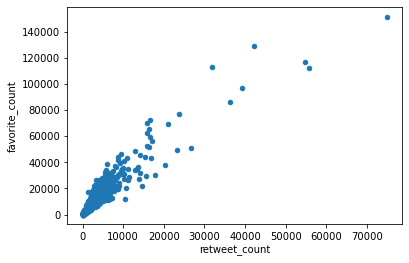

In [60]:
df_twitter_archive_dogs_only.plot.scatter(x='retweet_count', y='favorite_count');

We can notice that there is a correlation between the number of favorite and the number of retweet.
### Dog stages

In [61]:
dogs_with_stage = df_twitter_archive_dogs_only[~df_twitter_archive_dogs_only.dog_stage.isna()]
dog_stage_ratio = dogs_with_stage.shape[0] / df_twitter_archive_dogs_only.shape[0]
print("There are {:.1f}% of the tweets, predicted as dogs, were the user gave the stage of his dog.".format(dog_stage_ratio * 100))

There are 15.0% of the tweets, predicted as dogs, were the user gave the stage of his dog.


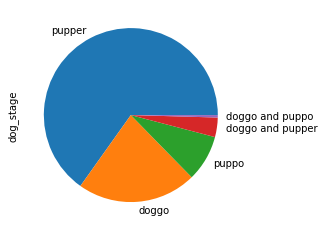

In [62]:
dogs_with_stage.dog_stage.value_counts().plot.pie();

Out of those dog with a given stage, we can notice that there are mostly some Puppers.